In [1]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import random
import time

import plotly.graph_objects as go
import numpy as np

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

import seaborn as sns

import pyro
import pyro.distributions as dist
import pyro.nn as nn

import dill

from typing import List, Dict, Tuple, Optional

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from collab2.utils import find_repo_root

root = find_repo_root()
from collab2.foraging import random_hungry_followers as rhf
from collab2.foraging import toolkit as ft
from collab2.foraging.toolkit.animate_foragers import new_animate_foragers
from IPython.display import HTML

logging.basicConfig(format="%(message)s", level=logging.INFO)

# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import random
import dill
import time

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

from collab2.utils import find_repo_root

root = find_repo_root()
from collab2.foraging import random_hungry_followers as rhf
import collab2.foraging.toolkit as ft

from collab2.foraging.toolkit import (
    animate_predictors,
    constraint_filter_nearest,
    dataObject,
    generate_local_windows,
    plot_predictor,
    rescale_to_grid,
    subsample_frames_constant_frame_rate,
)


logging.basicConfig(format="%(message)s", level=logging.INFO)

# users can ignore smoke_test -- it's for automatic testing on GitHub, to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
#smoke_test = True
num_frames = 5 if smoke_test else 50
num_svi_iters = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 1000
 
notebook_starts = time.time()

In [2]:
random.seed(23)
np.random.seed(23)

hungry_sim = rhf.Foragers(
    grid_size=60, num_foragers=3, num_frames=num_frames, num_rewards=60, grab_range=3
)

hungry_sim()


#serialize hungry_sim using dill, as this simulation takes a bit of time
# if hungry sim not in folder, generate, otherwise load

if not os.path.exists("hungry_sim.dill"):

    hungry_sim = rhf.Foragers(
    grid_size=60, num_foragers=3, num_frames=num_frames, num_rewards=60, grab_range=3
    )

    hungry_sim()

    hungry_sim = rhf.add_hungry_foragers(
        hungry_sim, num_hungry_foragers=3, rewards_decay=0.3, visibility_range=6
    )


    with open("hungry_sim.dill", "wb") as f:
        dill.dump(hungry_sim, f)

else:
    print("Loading existing simulation results")
    with open("hungry_sim.dill", "rb") as f:
        hungry_sim = dill.load(f)

display(hungry_sim.foragersDF)


Loading existing simulation results


x     y  time  forager    type
0   34.0  33.0     0        0  hungry
1   31.0  38.0     1        0  hungry
2   34.0  39.0     2        0  hungry
3   29.0  41.0     3        0  hungry
4   26.0  45.0     4        0  hungry
..   ...   ...   ...      ...     ...
45  52.0  60.0    45        2  hungry
46  53.0  56.0    46        2  hungry
47  55.0  53.0    47        2  hungry
48  57.0  54.0    48        2  hungry
49  51.0  54.0    49        2  hungry

[150 rows x 5 columns]

In [3]:
local_windows_kwargs = {
    "window_size": 10,
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}

predictor_kwargs = {
    "proximity": {
        "interaction_length": hungry_sim.grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "repulsion_radius": 1.5,
        "optimal_distance": 4,
        "proximity_decay": 1,
    },
    "food":
        {
          "decay_factor": 0.5,
        },
}

score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

derivedDF_hungry = ft.derive_predictors_and_scores(
    hungry_sim,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

display(derivedDF_hungry)

2024-09-17 14:46:59,279 - proximity completed in 0.47 seconds.
2024-09-17 14:47:00,454 - food completed in 1.17 seconds.
2024-09-17 14:47:00,637 - nextStep_linear completed in 0.18 seconds.
2024-09-17 14:47:00,795 - nextStep_sublinear completed in 0.16 seconds.
/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/derive.py:56: UserWarning: 
                      Dropped 885/40498 frames from `derivedDF` due to NaN values.
                      Missing values can arise when computations depend on next/previous step positions
                      that are unavailable. See documentation of the corresponding predictor/score generating
                      functions for more information.
                      
  warnings.warn(


x   y  distance_to_forager  time  forager  proximity      food  \
0      24  33            10.000000     0        0   0.319965  0.206636   
1      25  29             9.848858     0        0   0.780743  0.320200   
2      25  30             9.486833     0        0   0.923782  0.351253   
3      25  31             9.219544     0        0   0.969958  0.312688   
4      25  32             9.055385     0        0   0.808956  0.238773   
...    ..  ..                  ...   ...      ...        ...       ...   
40241  59  55             2.236068    48        2   0.000000  0.000000   
40242  59  56             2.828427    48        2   0.000000  0.000000   
40243  59  57             3.605551    48        2   0.000000  0.000000   
40244  59  58             4.472136    48        2   0.000000  0.000000   
40245  59  59             5.385165    48        2   0.000000  0.000000   

       distance_to_next_step  nextStep_linear  nextStep_sublinear  \
0                   8.602325         0.455941            0.262397   
1                  10.816654         0.315895            0.172893   
2                  10.000000         0.367544            0.204729   
3                   9.219544         0.416905            0.236393   
4                   8.485281         0.463344            0.267432   
...                      ...              ...                 ...   
40241               8.062258         0.330466            0.181749   
40242               8.246211         0.315189            0.172467   
40243               8.544004         0.290459            0.157657   
40244               8.944272         0.257219            0.138152   
40245               9.433981         0.216551            0.114873   

       proximity_scaled  food_scaled  nextStep_linear_scaled  \
0              0.659982     0.206636                0.455941   
1              0.890371     0.320200                0.315895   
2              0.961891     0.351253                0.367544   
3              0.984979     0.312688                0.416905   
4              0.904478     0.238773                0.463344   
...                 ...          ...                     ...   
40241          0.500000     0.000000                0.330466   
40242          0.500000     0.000000                0.315189   
40243          0.500000     0.000000                0.290459   
40244          0.500000     0.000000                0.257219   
40245          0.500000     0.000000                0.216551   

       nextStep_sublinear_scaled  
0                       0.262397  
1                       0.172893  
2                       0.204729  
3                       0.236393  
4                       0.267432  
...                          ...  
40241                   0.181749  
40242                   0.172467  
40243                   0.157657  
40244                   0.138152  
40245                   0.114873  

[39613 rows x 14 columns]

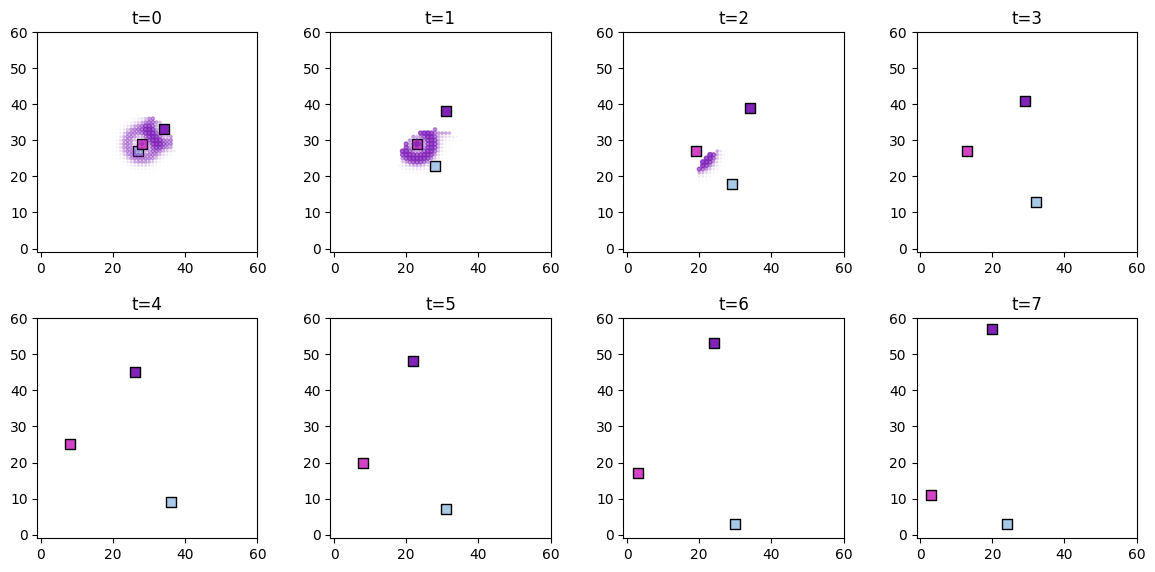

In [4]:
plot_predictor(
    hungry_sim.foragers,
    hungry_sim.derived_quantities['proximity'],
    predictor_name = "proximity",
    time = range(min(8,num_frames)),
    grid_size = 60,
    size_multiplier=10,
    random_state=99,
    forager_position_indices =  [0,1,2],
    forager_predictor_indices = [1],
)

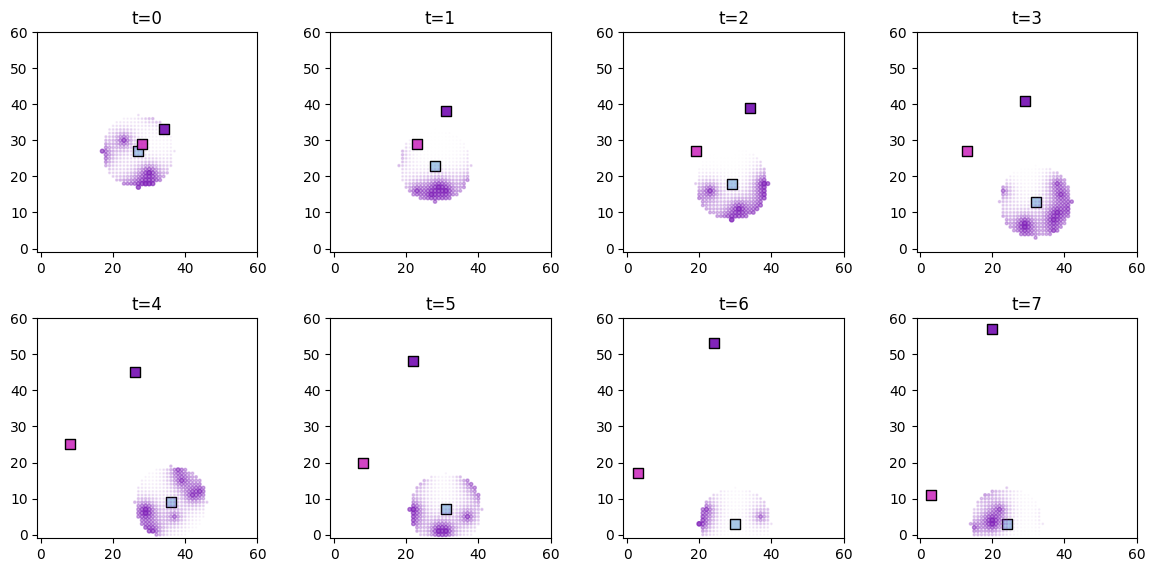

In [5]:
plot_predictor(
    hungry_sim.foragers,
    hungry_sim.derived_quantities['food'],
    predictor_name = "food",
    time = range(min(8,num_frames)),
    grid_size =60,
    size_multiplier=10,
    random_state=99,
    forager_position_indices =  [0,1,2],
    forager_predictor_indices = [1],
)

2024-09-17 14:47:03,236 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


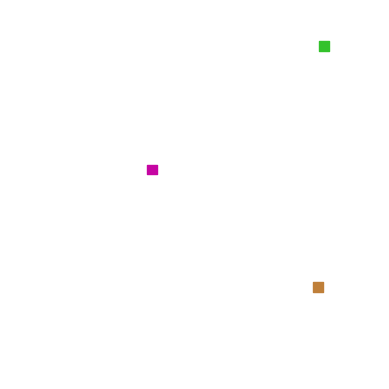

In [6]:
ani = animate_predictors(
    hungry_sim.foragersDF,
    hungry_sim.derived_quantities['proximity'],
    predictor_name="proximity",
    forager_position_indices=[0,1,2],
    forager_predictor_indices=[1],
    grid_size=60,
    random_state=10,
    size_multiplier=10,
)
HTML(ani.to_jshtml())

2024-09-17 14:47:03,984 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


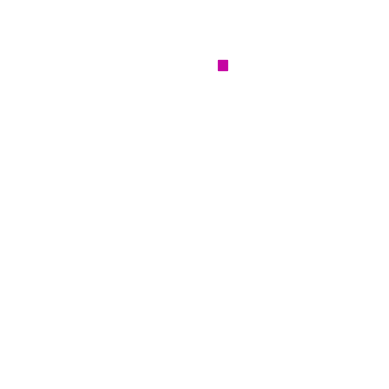

In [7]:
ani = animate_predictors(
    hungry_sim.foragersDF,
    hungry_sim.derived_quantities['food'],
    predictor_name="food",
    forager_position_indices=[0,1,2],
    forager_predictor_indices=[1],
    grid_size=40,
    random_state=10,
    size_multiplier=15,
)
HTML(ani.to_jshtml())

In [8]:

predictors = ['proximity_scaled', 'food_scaled', 'distance_to_forager']
outcome_vars = ['nextStep_linear']


predictor_tensors_hungry, outcome_tensor_hungry = ft.prep_data_for_inference(hungry_sim, predictors, outcome_vars)


In [9]:
# plot outcome vs predictors
ft.visualise_forager_predictors(
    predictors = [predictor_tensors_hungry['proximity_scaled'], 
                  predictor_tensors_hungry['food_scaled'],
                  predictor_tensors_hungry['distance_to_forager']],
    predictor_names=['proximity_scaled', 'food_scaled', 'distance_to_forager'],
    outcome_name="hungryep_linear",
    outcome=outcome_tensor_hungry['nextStep_linear'],
    sampling_rate=.5,
)

/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning:

Can't initialize NVML



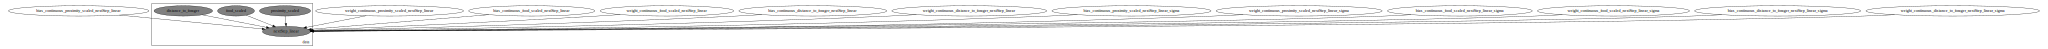

In [10]:
model_sigmavar_hungry = ft.HeteroskedasticLinear(predictor_tensors_hungry, outcome_tensor_hungry)
pyro.render_model(
    model_sigmavar_hungry,
    model_args=(predictor_tensors_hungry, outcome_tensor_hungry),
    render_deterministic = True
)

2024-09-17 14:47:08,129 - Starting SVI inference with 1500 iterations.


[iteration 0001] loss: 1117504.6250
[iteration 0050] loss: 1135453.3750
[iteration 0100] loss: 1132062.7500
[iteration 0150] loss: 1139034.2500
[iteration 0200] loss: 1129248.1250
[iteration 0250] loss: 1117428.7500
[iteration 0300] loss: 1124409.6250
[iteration 0350] loss: 1115523.7500
[iteration 0400] loss: 1120021.8750
[iteration 0450] loss: 1104229.8750
[iteration 0500] loss: 1118399.3750
[iteration 0550] loss: 1071347.2500
[iteration 0600] loss: 1084787.8750
[iteration 0650] loss: 1081070.3750
[iteration 0700] loss: 1072625.2500
[iteration 0750] loss: 1082991.7500
[iteration 0800] loss: 1080064.5000
[iteration 0850] loss: 1084043.7500
[iteration 0900] loss: 1074849.2500
[iteration 0950] loss: 1128930.8750
[iteration 1000] loss: 1085242.1250
[iteration 1050] loss: 1071865.6250
[iteration 1100] loss: 1075559.7500
[iteration 1150] loss: 1074416.1250
[iteration 1200] loss: 1089836.2500
[iteration 1250] loss: 1071421.1250
[iteration 1300] loss: 1068816.7500
[iteration 1350] loss: 10728

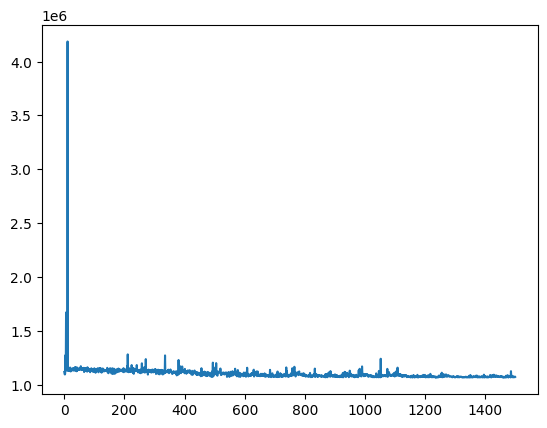

2024-09-17 14:47:34,232 - SVI inference completed in 26.10 seconds.


dict_keys(['bias_continuous_proximity_scaled_nextStep_linear', 'weight_continuous_proximity_scaled_nextStep_linear', 'bias_continuous_food_scaled_nextStep_linear', 'weight_continuous_food_scaled_nextStep_linear', 'bias_continuous_distance_to_forager_nextStep_linear', 'weight_continuous_distance_to_forager_nextStep_linear', 'bias_continuous_proximity_scaled_nextStep_linear_sigma', 'weight_continuous_proximity_scaled_nextStep_linear_sigma', 'bias_continuous_food_scaled_nextStep_linear_sigma', 'weight_continuous_food_scaled_nextStep_linear_sigma', 'bias_continuous_distance_to_forager_nextStep_linear_sigma', 'weight_continuous_distance_to_forager_nextStep_linear_sigma', 'proximity_scaled', 'food_scaled', 'distance_to_forager', 'nextStep_linear'])
['weight_continuous_proximity_scaled_nextStep_linear', 'weight_continuous_food_scaled_nextStep_linear', 'weight_continuous_distance_to_forager_nextStep_linear']
Coefficient marginals:
Site: weight_continuous_proximity_scaled_nextStep_linear
     m

In [11]:

results_hungry = ft.get_samples(model =  model_sigmavar_hungry, predictors= predictor_tensors_hungry, outcome= outcome_tensor_hungry, num_svi_iters=1500, num_samples = 1000)


In [12]:
selected_sites = [key for key in results_hungry['samples'].keys() if key.startswith("weight") and not key.endswith("sigma")]
selected_samples = {key: results_hungry['samples'][key] for key in selected_sites}  

ft.plot_coefs(
    selected_samples, "Hungry foragers", nbins=120, ann_start_y=160, ann_break_y=50
)


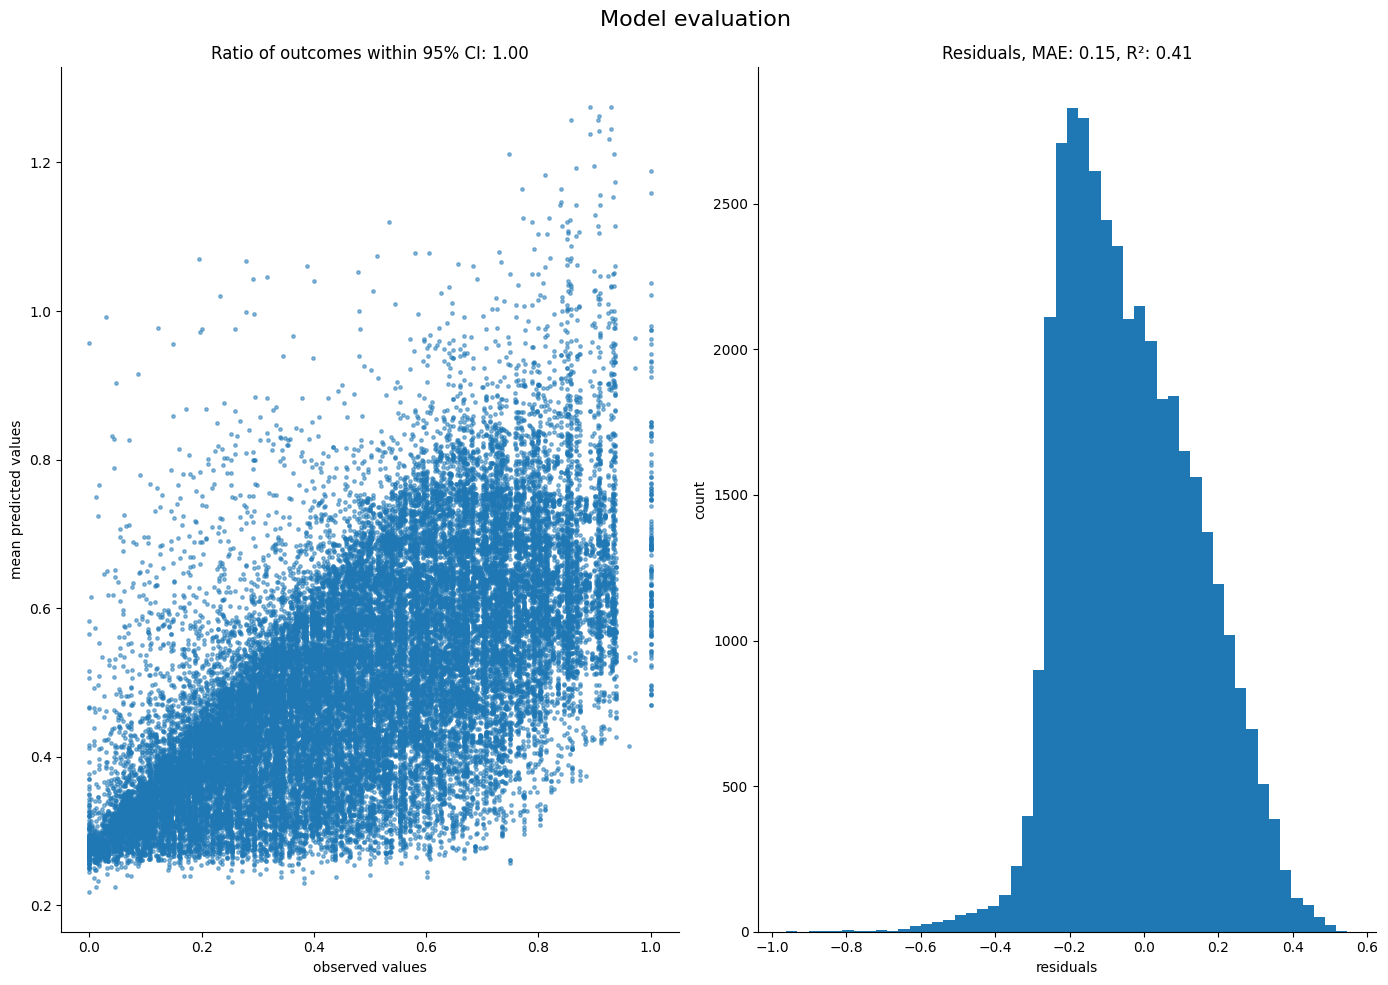

In [13]:
ft.evaluate_performance(model =  model_sigmavar_hungry, guide =results_hungry['guide'], 
                        predictors= predictor_tensors_hungry, 
                        outcome= outcome_tensor_hungry,
                        num_samples = 1000)